# Simulated transit residuals

Load deconvolved images, simulate an Earth-like transit on each one:

/Users/bmmorris/anaconda/lib/python3.5/site-packages/glymur/config.py:171: UserWarning: Neither the openjp2 nor the openjpeg library could be loaded.  
  warnings.warn(msg)


RuntimeError: module compiled against API version 0xc but this version of numpy is 0xa

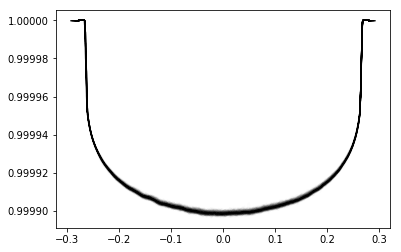

In [1]:
%matplotlib inline
import astropy.units as u
from astropy.constants import R_earth, R_sun
from sunpy.map import Map
from stash import simulate_lightcurve
import matplotlib.pyplot as plt
from astropy.io import fits
from glob import glob
from tqdm import tqdm

paths = glob('decon/*.fits')

# Set up planet parameters
orbital_period = 365 * u.day
semimajor_axis = 1 * u.AU
impact_parameter = 0.0
R_planet = R_earth
R_star = R_sun
lightcurves = []

for path in paths[3:]:
    f = fits.open(path, memmap=False, lazy_load_hdus=True)
    f[1].verify('silentfix')

    # Simulate a light curve for that system, return a `LightCurve` object
    lc = simulate_lightcurve(f[1].data, orbital_period, semimajor_axis,
                             impact_parameter, R_planet, R_star)#, supersample_factor=4)

    if lc.times.min() < -0.4: 
        pass

    else: 
        # Plot the resulting light curve
        lc.plot(alpha=0.01, color='k')
        lightcurves.append(lc)

plt.gca().ticklabel_format(useOffset=False)
# Show me the plot!
plt.show()

Make a plot to show the spread at the bottom of transit

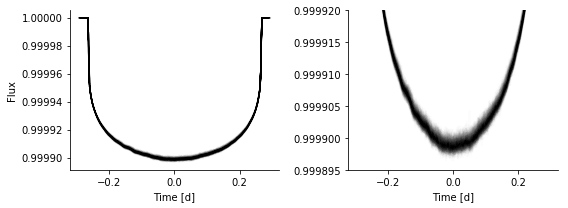

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
for lc in lightcurves: 
    
    lc.plot(ax=ax[0], alpha=0.01, color='k')

    lc.plot(ax=ax[1], alpha=0.01, color='k')

    
ax[0].ticklabel_format(useOffset=False)
ax[0].set_xlabel('Time [d]')
ax[0].set_ylabel('Flux')

ax[1].set_ylim([0.999895, 0.99992])
ax[1].set_xlabel('Time [d]')
fig.tight_layout()

for axis in ax: 
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)

plt.savefig('paper_plots/lc.pdf', bbox_inches='tight')
# Show me the plot!
plt.show()

In [3]:
len(lightcurves)

252

Set up parameters for a fit to the transit light curve: 

In [13]:
from batman import TransitParams
import numpy as np

params = TransitParams()
params.per = 365
params.rp = float(R_earth/R_sun)
params.a = float(1*u.AU/R_sun)
params.inc = 89.9

# Sing 2009: https://arxiv.org/pdf/0912.2274.pdf
params.u = [0.6283, -0.3063, 0.8965, -0.4593] #[0.45, 0.0, 0.19, 0.0]
# params.u = [0.45, 0.19]
# params.limb_dark = "quadratic"
params.limb_dark = "nonlinear"

params.ecc = 0
params.w = np.pi/2
params.t0 = 0

Fit each transit light curve with a Mandel & Agol (2002) transit model, save the residuals: 

In [15]:
residuals = []
for lc in tqdm(lightcurves):
    try: 
        transit_model = lc.get_transit_model(params, 1e-6)

        residuals.append(lc.fluxes - transit_model.fluxes)
    except Exception:
        pass


100%|██████████| 252/252 [5:25:31<00:00, 19.99s/it]


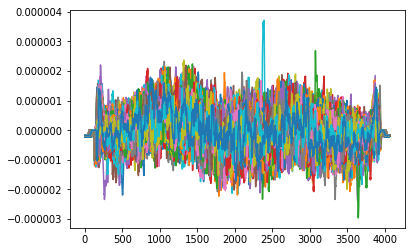

In [16]:
for r in residuals:
    plt.plot(r)

In [17]:
residuals = np.array(residuals)

`cropped_residuals` is a matrix of residuals that have been cleaned of any transits with spot occultations:

In [18]:
cropped_residuals = residuals[np.max(residuals, axis=1) < 5e-6]

Plot the residuals from every transit on top of one another to show the correlated noise: 

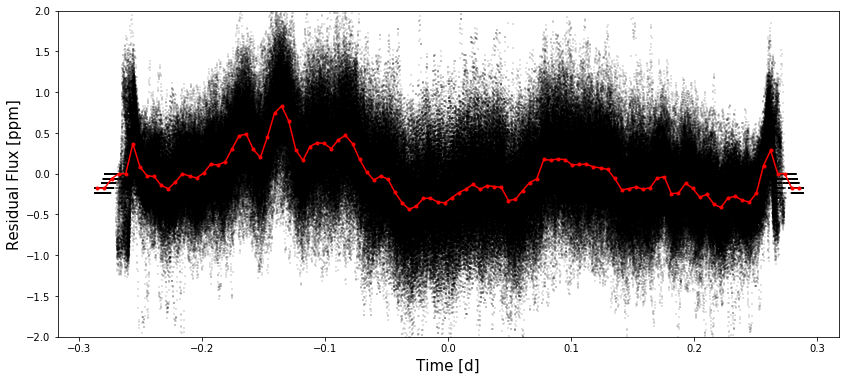

In [19]:
plt.figure(figsize=(14, 6))
for r in cropped_residuals:
    if r.max() < 5e-6:
        plt.scatter(transit_model.times, r*1e6, marker=',', color='k', s=1, alpha=0.1)

from scipy.stats import binned_statistic 

bs = binned_statistic(np.tile(transit_model.times, cropped_residuals.shape[0]), 
                      cropped_residuals.ravel(), statistic='median', bins=100)
bincenters = 0.5 * (bs.bin_edges[:-1] + bs.bin_edges[1:])
plt.plot(bincenters, 1e6 * bs.statistic, color='r', marker='.')
        
fontsize = 15
plt.xlabel('Time [d]', fontsize=fontsize)
plt.ylabel('Residual Flux [ppm]', fontsize=fontsize)
plt.ylim([-2, 2])
plt.savefig('residuals_decon.png', bbox_inches='tight', dpi=250)

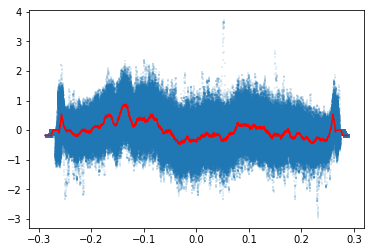

In [20]:
plt.scatter(np.tile(transit_model.times, cropped_residuals.shape[0]), 1e6*cropped_residuals, marker=',', s=1, alpha=0.1)
plt.plot(transit_model.times, 1e6*np.median(cropped_residuals, axis=0), 'r')

In [31]:
# corrected_residuals = 1e6*(cropped_residuals - np.median(cropped_residuals, axis=0))

# fontsize = 15
# fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
# ax[0].scatter(np.tile(transit_model.times, cropped_residuals.shape[0]), corrected_residuals, 
#               marker=',', s=1, alpha=0.05, rasterized=True, color='k')
# ax[1].hist(corrected_residuals.ravel(), orientation='horizontal', 
#            bins=100, log=True, histtype='stepfilled', color='k')

# for axis in ax: 
#     for s in ['right', 'top']:
#         axis.spines[s].set_visible(False)
# # ax[1].spines['bottom'].set_visible(False)
# # # ax[1].set_xticks([])
# ax[1].set_xlim([1e1, 1e5])
# ax[0].set_xlabel('Time [d]', fontsize=fontsize)
# ax[0].set_ylabel('Residuals [ppm]', fontsize=fontsize)
# ax[1].set_xlabel('Frequency', fontsize=fontsize)

# fig.savefig('paper_plots/corrected_residuals.pdf', bbox_inches='tight', dpi=300)
# plt.show()

### Make residual plot for paper: 

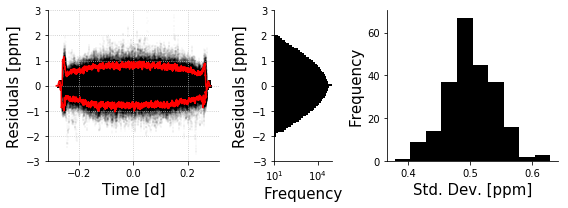

In [22]:
corrected_residuals = 1e6*(cropped_residuals - np.median(cropped_residuals, axis=0))

fontsize = 15
# fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 3))
gs = GridSpec(1, 5, figure=fig)

ax0 = plt.subplot(gs[0:2])

ax1 = plt.subplot(gs[2])

ax2 = plt.subplot(gs[3:5])

ax0.scatter(np.tile(lightcurves[0].times, cropped_residuals.shape[0]), corrected_residuals, 
              marker=',', s=1, alpha=0.01, rasterized=True, color='k')
ax0.grid(ls=':', color='silver')

ax0.plot(lightcurves[0].times, np.percentile(corrected_residuals, 95, axis=0), color='r')
ax0.plot(lightcurves[0].times, np.percentile(corrected_residuals, 5, axis=0), color='r')

ax1.hist(corrected_residuals.ravel(), orientation='horizontal', 
           bins=100, log=True, histtype='stepfilled', color='k')

ax2.hist(1e6*cropped_residuals.std(axis=1), histtype='stepfilled', color='k')

ax2.set_xlabel('Std. Dev. [ppm]', fontsize=fontsize)
ax2.set_ylabel('Frequency', fontsize=fontsize)

for axis in [ax0, ax1, ax2]: 
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
# ax[1].spines['bottom'].set_visible(False)
# # ax[1].set_xticks([])
ax1.set_xlim([1e1, 1e5])
ax0.set_ylim([-3, 3])
ax1.set_ylim([-3, 3])

ax0.set_xlabel('Time [d]', fontsize=fontsize)
ax0.set_ylabel('Residuals [ppm]', fontsize=fontsize)
ax1.set_ylabel('Residuals [ppm]', fontsize=fontsize)
ax1.set_xlabel('Frequency', fontsize=fontsize)

fig.tight_layout()
fig.savefig('paper_plots/corrected_residuals.pdf', bbox_inches='tight', dpi=300)
plt.show()

Example residuals from a particular transit: 

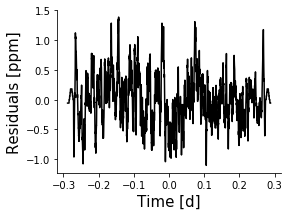

In [28]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(transit_model.times, corrected_residuals[0], color='k')
ax.set_xlabel('Time [d]', fontsize=fontsize)
ax.set_ylabel('Residuals [ppm]', fontsize=fontsize)
for s in ['right', 'top']:
    ax.spines[s].set_visible(False)
fig.savefig('paper_plots/example_residuals.pdf', bbox_inches='tight')
plt.show()

If you divide up the sun into 30 chunks, the periodicity in the residuals lines up nicely. Interesting!

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


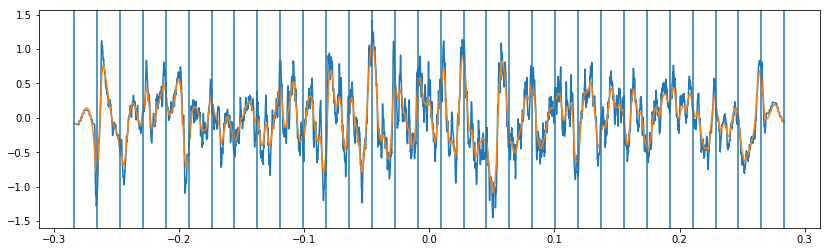

In [95]:
gp = celerite.GP(kernel)
gp.set_parameter_vector(np.median(sampler.flatchain, axis=0)[:-1])
gp.compute(x, yerr=0.5)

mu = gp.predict(y, return_cov=False)

plt.figure(figsize=(14, 4))
plt.plot(x, y)
plt.plot(lightcurves[0].times, mu)

for t in np.linspace(lightcurves[0].times.min(), lightcurves[0].times.max(), 32):
    plt.axvline(t)

How well does the ACF of the GP fit the ACF of the observations?

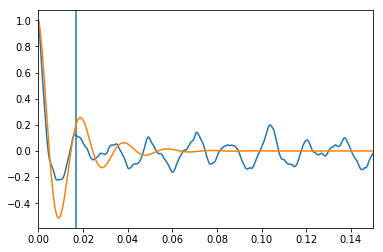

In [97]:
from interpacf import autocorrelation, interpolated_acf

acf = autocorrelation(y)
lags = np.arange(len(acf)) * (lightcurves[0].times[1] - lightcurves[0].times[0])

plt.plot(lags, acf/acf.max())
# plt.ylim([-0.2, 0.3])
plt.xlim([0, 0.15])
plt.axvline(0.017)

model_acf = gp.kernel.get_value(lags)

plt.plot(lags, model_acf/model_acf.max())

In [540]:
delta_t = model.best_period * u.day

v = 2*np.pi*1*u.AU / (365 * u.day)

(delta_t*v).to(u.Mm)

<Quantity 43.4155033500272 Mm>

In [29]:
np.save('cropped_residuals.npy', cropped_residuals)

In [30]:
np.save('corrected_residuals.npy', corrected_residuals)

In [93]:
corrected_residuals = np.load('corrected_residuals.npy')